This notebook was written by Kieran Loehr to analyzing an algorithm for finding the maximum of a 3D gaussian with time-varying noise. This uses the natural evolution strategy with a search distribution of a gaussian with varying mean, but fixed diagonal covariant matrix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

The parameters used to describe the environment are:

1) SNR (provide the signal and noise magnitudes seperately)

2) Signal parameters assuming we are focusing on a gaussian ($\mu_x$, $\sigma_x$, $\mu_y$, $\sigma_y$, $\mu_z$, $\sigma_z$)

In [1]:
### Define the environment signal
def gaussian(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag):
  f = signal_mag*np.exp(-((x - mu_x) ** 2 / (2 * sigma_x ** 2) + (y - mu_y) ** 2 / (2 * sigma_y ** 2)+ (z - mu_z) ** 2 / (2 * sigma_z ** 2)))
  return f

def noisy_gaussian(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise):
  f = gaussian(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,signal_mag)
  noisy_f =  f + np.random.normal(0, noise, f.shape)   
  return noisy_f

In [2]:
### User inputs for the environment
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag, noise = 1, 0.01

The parameters provided by the user for this algorithm are:

1) Search Distribution 

2) Learning Rate

3) Number of samples

4) Utility function

In [4]:
### Define the algorithm inputs
def search_distribution(x,y,z,theta_x,theta_y,theta_z,sigma):
  normalization = 1/np.sqrt((2*np.pi*sigma**2)**3)
  vec = np.array([x-theta_x,y-theta_y, z-theta_z])
  m = np.matmul(vec,vec)/(sigma**2)
  return normalization*np.exp(-m/2)

### This is taken from Daan Wierstra's 2014 paper "Natura Evolution Strategies" 
def utility(k,lam):
  numerator = np.maximum(0,np.log(lam/2 + 1)-np.log(k))
  denominator = 0
  for j in range(lam):
    denominator += np.maximum(0,np.log(lam/2 + 1)-np.log(j+1))
  return numerator/denominator - 1/lam

In [5]:
### User inputs for NES
### Search distribution parameters
sigma = 0.5
### Learning rate
eta = 1
### Number of samples
lam = 5

def pi(x,y,z,theta_x,theta_y,theta_z, sigma):
  return search_distribution(x,y,z,theta_x,theta_y,theta_z, sigma)

def f(x,y,z,mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,signal_mag,noise):
  return noisy_gaussian(x,y,z,mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z,signal_mag,noise)

def grad_log_pi(x,y,z,theta_x,theta_y,theta_z, sigma):
  g_x = 2*(x-theta_x)/(sigma**2)
  g_y = 2*(y-theta_y)/(sigma**2)
  g_z = 2*(z-theta_z)/(sigma**2)
  return np.array([g_x,g_y,g_z])

This cell runs the NES algorithm.



In [6]:
def NES_step(theta, sigma, u_k, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise):
  theta_x,theta_y,theta_z = theta[0],theta[1],theta[2]
  samples = np.random.multivariate_normal(theta, sigma**2*np.identity(3), lam)
  fits = np.zeros(lam)
  grads_log_pi = np.zeros((lam,3))
  for i in range(len(samples)):
    x,y,z = samples[i,0],samples[i,1],samples[i,2]
    fits[i] = f(x,y,z,mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise)
    grads_log_pi[i,:] = grad_log_pi(x,y,z,theta_x,theta_y,theta_z,sigma)
  grads_log_pi_sorted = grads_log_pi[fits.argsort()]

  gradJ = 1/lam*np.einsum('i,ij->j',u_k,grads_log_pi_sorted)
  F = 1/lam*np.einsum('ij,ik->jk',grads_log_pi_sorted,grads_log_pi_sorted)
  
  theta = theta + eta*np.matmul(np.linalg.inv(F),gradJ)
  return(theta)

The cell below defines runs of NES and how we can define them as successes.

In [7]:
def run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps):
  u_k = np.zeros(lam)
  for i in range(lam):
    u_k[-(i+1)] = utility(i+1,lam)

  location = [theta]
  intensity = [f(theta[0],theta[1],theta[2], mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise)]
  for i in range(steps):
    theta = NES_step(theta, sigma, u_k, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise)
    location.append(theta)
    intensity.append(f(theta[0],theta[1],theta[2], mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise))
  return np.array(location), np.array(intensity)

In [8]:
def success(locations):
  threshold = 0.225
  distances = np.linalg.norm(locations,axis=1)
  first_entrance = np.argmax(distances>threshold)
  last_batch = distances[first_entrance:]
  count = (last_batch < threshold).sum()
  return count > len(last_batch)/2

def success_rate(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps, average_size):
  successes = 0
  for i in range(average_size):
    location, intensity = run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps)
    successes += success(location)
  return successes

In [9]:
def time_count(locations):
  threshold = 0.225
  distances = np.linalg.norm(locations,axis=1)
  b_distances = (distances < threshold).astype(int)
  combined_ints = b_distances + np.roll(b_distances,-1) + np.roll(b_distances,-2) + np.roll(b_distances,-3) + np.roll(b_distances,-4)
  return np.argmax(combined_ints == 5)

def average_time(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps, average_size):
  duration = 0
  nonZ = 0
  for i in range(average_size):
    location, intensity = run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps)
    tc = time_count(location)
    if tc != 0:
      duration += tc
      nonZ += 1
  return duration/nonZ

The cells below evaluate the success rate of NES as a function of the SNR.

1.0
0.4641588833612779
0.38311868495572876
0.31622776601683794
0.26101572156825364
0.2154434690031884
0.1778279410038923
0.14677992676220694
0.12115276586285885
0.1
0.046415888336127795
0.021544346900318832
0.01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


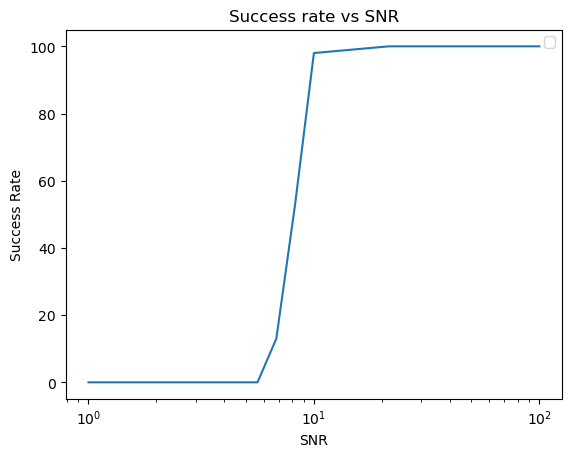

[  1.           2.15443469   2.61015722   3.16227766   3.83118685
   4.64158883   5.62341325   6.81292069   8.25404185  10.
  21.5443469   46.41588834 100.        ]
[  0.   0.   0.   0.   0.   0.   0.  13.  53.  98. 100. 100. 100.]


In [10]:
theta = np.array([1,1,1])
sigma = 0.1
eta = 50
lam = 15
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag = 1
steps = 300
average_size = 100

noises = 10**np.array([0, -1/3,-5/12,-1/2,-7/12, -2/3,-3/4, -5/6, -11/12,-1, -4/3,-5/3,-2])
success_rates = np.zeros(len(noises))
for i in range(len(noises)):
  noise = noises[i]
  print(noise)
  success_rates[i] = success_rate(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps, average_size)

plt.plot(1/noises, success_rates)
plt.title('Success rate vs SNR')
plt.xlabel('SNR')
plt.ylabel('Success Rate')
plt.xscale("log")
plt.legend()
plt.show()
print(1/noises)
print(success_rates)

1.0
0.4641588833612779
0.38311868495572876
0.31622776601683794
0.26101572156825364
0.2154434690031884
0.1778279410038923
0.14677992676220694
0.12115276586285885
0.1
0.046415888336127795
0.021544346900318832
0.01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


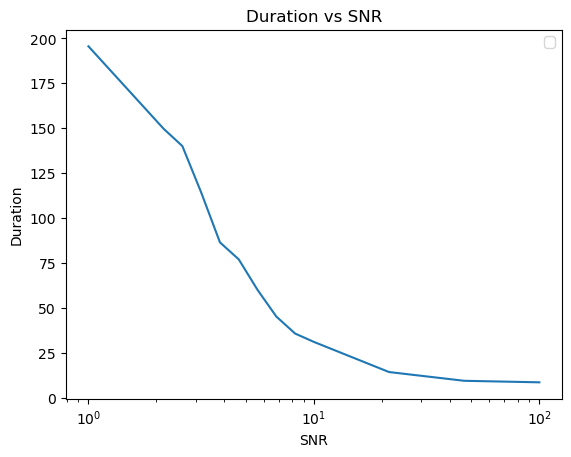

[  1.           2.15443469   2.61015722   3.16227766   3.83118685
   4.64158883   5.62341325   6.81292069   8.25404185  10.
  21.5443469   46.41588834 100.        ]
[195.5        149.63095238 139.95454545 114.16326531  86.37373737
  76.92        59.94        45.09        35.64        30.98
  14.21         9.34         8.49      ]


In [11]:
theta = np.array([1,1,1])
sigma = 0.1
eta = 50
lam = 15
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag = 1
steps = 300
average_size = 100

noises = 10**np.array([0, -1/3,-5/12,-1/2,-7/12, -2/3,-3/4, -5/6, -11/12,-1, -4/3,-5/3,-2])
durations = np.zeros(len(noises))
for i in range(len(noises)):
  noise = noises[i]
  print(noise)
  durations[i] = average_time(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps, average_size)

plt.plot(1/noises, durations)
plt.title('Duration vs SNR')
plt.xlabel('SNR')
plt.ylabel('Duration')
plt.xscale("log")
plt.legend()
plt.show()
print(1/noises)
print(durations)

In [24]:
print((1/noises))
print(success_rates)
print(durations)

[  1.           2.15443469   2.61015722   3.16227766   3.83118685
   4.64158883   5.62341325   6.81292069   8.25404185  10.
  21.5443469   46.41588834 100.        ]
[  0.   0.   0.   0.   0.   0.   2.  10.  61.  96. 100. 100. 100.]
[189.10714286 156.36842105 132.94680851 124.81632653  89.51515152
  73.67        56.79        45.18        36.72        28.86
  14.16         9.74         8.71      ]


0.1
0.046415888336127795
0.021544346900318832
0.01
0.004641588833612777
0.0021544346900318843
0.001


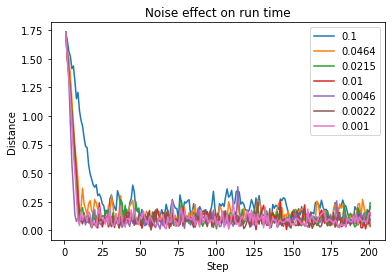

In [25]:
theta = np.array([1,1,1])
sigma = 0.1
eta = 50
lam = 15
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag = 1
steps = 200
average_size = 100

noises = np.array([10**(-1), 10**(-4/3),10**(-5/3),10**(-2),10**(-7/3),10**(-8/3),10**(-3)])
success_rates = np.zeros(len(noises))
for i in range(len(noises)):
  noise = noises[i]
  print(noise)
  location, intensity = run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps)
  distance = np.linalg.norm(location,axis=1)
  plt.plot(np.linspace(1,len(distance),len(distance)), distance, label = str(round(noise,4)))

plt.title('Noise effect on run time')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.legend()
plt.show()

0.1
0.2
0.4
1.0


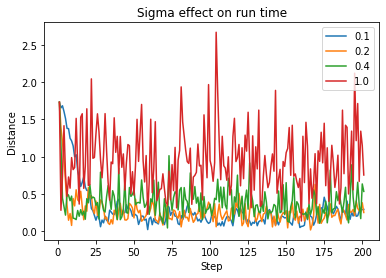

In [26]:
theta = np.array([1,1,1])
eta = 50
lam = 15
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag, noise = 1, 0.1
steps = 200
average_size = 100

sigmas = np.array([0.1,0.2,0.4,1])
success_rates = np.zeros(len(sigmas))
for i in range(len(sigmas)):
  sigma = sigmas[i]
  print(sigma)
  location, intensity = run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps)
  distance = np.linalg.norm(location,axis=1)
  plt.plot(np.linspace(1,len(distance),len(distance)), distance, label = str(round(sigma,4)))

plt.title('Sigma effect on run time')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.legend()
plt.show()

40
50


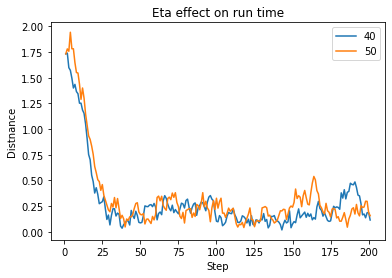

In [27]:
theta = np.array([1,1,1])
sigma = 0.1
lam = 15
mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z = 0,0,0,1,1,1
signal_mag, noise = 1, 0.1
steps = 200
average_size = 100

etas = np.array([40,50])
success_rates = np.zeros(len(etas))
for i in range(len(etas)):
  eta = etas[i]
  print(eta)
  location, intensity = run_NES_timed(theta, sigma, eta, lam, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z, signal_mag, noise, steps)
  distance = np.linalg.norm(location,axis=1)
  plt.plot(np.linspace(1,len(distance),len(distance)), distance, label = str(round(eta,4)))
  #if eta == 100:
    #print(intensity)

plt.title('Eta effect on run time')
plt.xlabel('Step')
plt.ylabel('Distnance')
plt.legend()
plt.show()

In [28]:
print((1/noises))
print(success_rates)
print(durations)

[  10.           21.5443469    46.41588834  100.          215.443469
  464.15888336 1000.        ]
[0. 0.]
[189.10714286 156.36842105 132.94680851 124.81632653  89.51515152
  73.67        56.79        45.18        36.72        28.86
  14.16         9.74         8.71      ]
